In [1]:
# Step 1: Clone repo and install packages
!git clone https://github.com/niaz1971/MALARIAL_CELL_CLASSIFICATION_USING_CNN.git
%cd MALARIAL_CELL_CLASSIFICATION_USING_CNN/
!pip install lime kaggle

Cloning into 'MALARIAL_CELL_CLASSIFICATION_USING_CNN'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (315/315), done.
remote: Compressing objects: 100% (311/311), done.
remote: Total 315 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (315/315), 4.85 MiB | 22.36 MiB/s, done.
Resolving deltas: 100% (18/18), done.
/content/MALARIAL_CELL_CLASSIFICATION_USING_CNN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b13249cf93b9c9ef2c67cc704e05265b8ab43482f0daefa27578da1726528fb7
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
# Step 2: Set up Kaggle API for dataset download
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Step 3: Download and unzip malaria cell images dataset
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -q cell-images-for-detecting-malaria.zip

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 96% 648M/675M [00:06<00:00, 271MB/s]
100% 675M/675M [00:07<00:00, 101MB/s]


In [4]:
# Step 4: Import required libraries
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.image as mpimg

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Step 5: Prepare directory structure for train, valid, test splits
original_dataset = 'cell_images'
parasitized_dir = os.path.join(original_dataset, 'Parasitized')
uninfected_dir = os.path.join(original_dataset, 'Uninfected')

base_dir = 'malaria_data'
os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

for d in [train_dir, valid_dir, test_dir]:
    os.makedirs(d, exist_ok=True)
classes = ['Parasitized', 'Uninfected']
for split_dir in [train_dir, valid_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

In [6]:
# Step 6: Function to split data into train, valid, test
def split_data(source_dir, train_dir, valid_dir, test_dir,
               train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):
    files = os.listdir(source_dir)
    random.shuffle(files)
    total = len(files)
    train_end = int(total * train_ratio)
    valid_end = train_end + int(total * valid_ratio)
    train_files = files[:train_end]
    valid_files = files[train_end:valid_end]
    test_files = files[valid_end:]
    for fname in train_files:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(train_dir, fname))
    for fname in valid_files:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(valid_dir, fname))
    for fname in test_files:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(test_dir, fname))

# Split data for both classes
split_data(parasitized_dir, os.path.join(train_dir, 'Parasitized'),
           os.path.join(valid_dir, 'Parasitized'),
           os.path.join(test_dir, 'Parasitized'))
split_data(uninfected_dir, os.path.join(train_dir, 'Uninfected'),
           os.path.join(valid_dir, 'Uninfected'),
           os.path.join(test_dir, 'Uninfected'))

In [7]:
# Step 7: Data augmentation and generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True,
                                   rotation_range=40, shear_range=0.2,
                                   width_shift_range=0.4, height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(128,128),
                                                    batch_size=32, class_mode='categorical',
                                                    shuffle=True, seed=42)
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(128,128),
                                                    batch_size=32, class_mode='categorical',
                                                    shuffle=True, seed=42)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(128,128),
                                                  batch_size=1, class_mode='categorical',
                                                  shuffle=False)
class_labels = train_generator.class_indices
class_names = {v: k for k, v in class_labels.items()}
print("Class labels:", class_labels)

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Class labels: {'Parasitized': 0, 'Uninfected': 1}


In [8]:
# Step 8: Build model with Xception base
base_model = Xception(weights='imagenet', include_top=False, input_shape=(128,128,3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(4608, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1152, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 31,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add[0][0]       

 Total params: 177,172,906 (675.86 MB)

 Trainable params: 156,311,426 (596.28 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [9]:
# Step 9: Compile model
optimizer = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [10]:
# Step 10: Define callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1),
             ModelCheckpoint('best_malaria_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
             ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=0.0001)]

In [11]:
# Step 11: Train model
history = model.fit(train_generator, steps_per_epoch=50, epochs=10,
                    validation_data=valid_generator, callbacks=callbacks)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6724 - loss: 0.6017
Epoch 1: val_loss improved from inf to 0.37847, saving model to best_malaria_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6735 - loss: 0.6002 - val_accuracy: 0.8632 - val_loss: 0.3785 - learning_rate: 1.0000e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7960 - loss: 0.4480
Epoch 2: val_loss improved from 0.37847 to 0.34350, saving model to best_malaria_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 526ms/step - accuracy: 0.7965 - loss: 0.4475 - val_accuracy: 0.8636 - val_loss: 0.3435 - learning_rate: 1.0000e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8052 - loss: 0.4275
Epoch 3: val_loss improved from 0.34350 to 0.33229, saving model to best_malaria_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 630ms/step - accuracy: 0.8056 - loss: 0.4270 - val_accuracy: 0.8599 - val_loss: 0.3323 - learning_rate: 1.0000e-04
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━

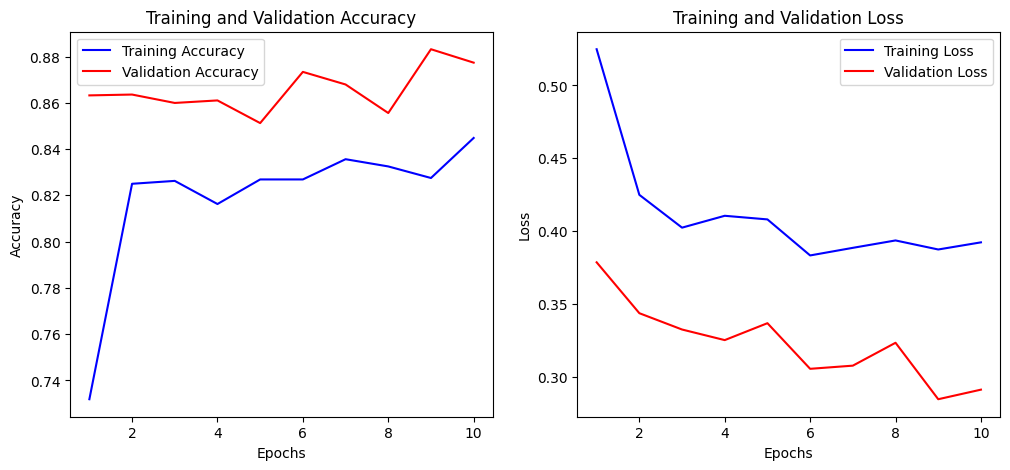

In [12]:
# Step 12: Plot training and validation curves
def plot_training_curves(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_training_curves(history)

In [13]:
# Step 13: Load best saved model
model = tf.keras.models.load_model('best_malaria_model.keras')

In [14]:
# Step 14: Evaluate model on validation and test sets
val_loss, val_acc = model.evaluate(valid_generator)
test_loss, test_acc = model.evaluate(test_generator)
print(f'Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.8851 - loss: 0.2732
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.8238 - loss: 0.3719
Validation Accuracy: 0.8832, Validation Loss: 0.2844
Test Accuracy: 0.8774, Test Loss: 0.2993


2756/2756 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step
              precision    recall  f1-score   support

 Parasitized       0.94      0.81      0.87      1378
  Uninfected       0.83      0.95      0.89      1378

    accuracy                           0.88      2756
   macro avg       0.88      0.88      0.88      2756
weighted avg       0.88      0.88      0.88      2756

Overall Test Accuracy: 0.8774


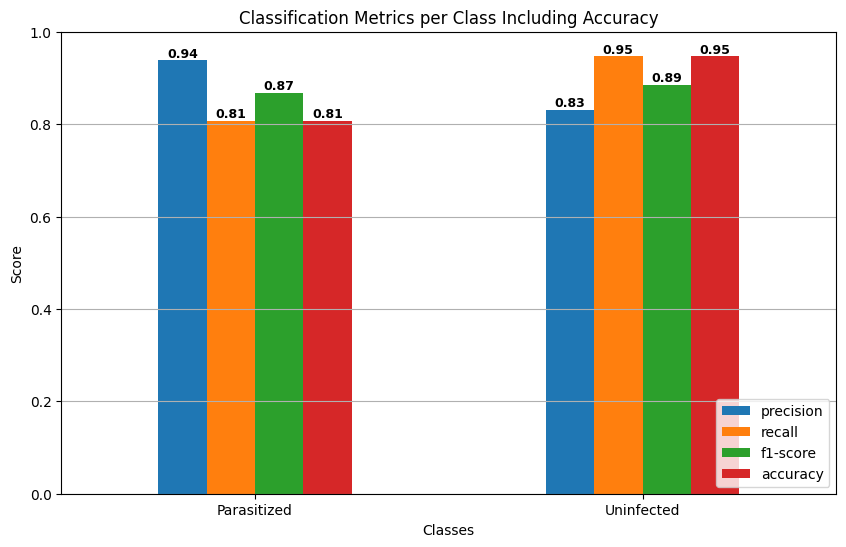


Overall Accuracy: 0.8774


In [15]:
# Step 15: Predict on test set and classification report
nb_samples = len(test_generator.filenames)
preds = model.predict(test_generator, steps=nb_samples, verbose=1)
pred_labels = np.argmax(preds, axis=1)
print(classification_report(test_generator.classes, pred_labels,
                            target_names=[class_names[i] for i in range(2)]))

accuracy = accuracy_score(test_generator.classes, pred_labels)
print(f'Overall Test Accuracy: {accuracy:.4f}')

# Plot classification metrics bar chart
report_dict = classification_report(test_generator.classes, pred_labels,
                                    target_names=[class_names[i] for i in range(2)],
                                    output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_classes = report_df.iloc[:-3, :-1]
cm = confusion_matrix(test_generator.classes, pred_labels)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
report_classes['accuracy'] = class_accuracies
ax = report_classes[['precision', 'recall', 'f1-score', 'accuracy']].plot(kind='bar', figsize=(10,6))
plt.title('Classification Metrics per Class Including Accuracy')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.ylim([0,1])
plt.xticks(rotation=0)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x()+p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()
print(f"\nOverall Accuracy: {accuracy:.4f}")

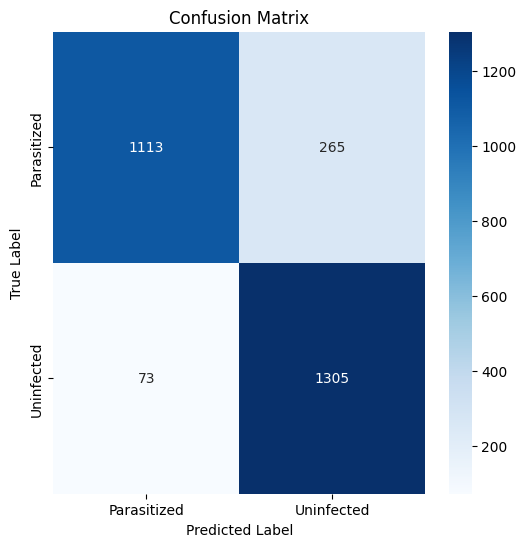

In [16]:
# Step 16: Confusion matrix plot
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names.values(),
            yticklabels=class_names.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

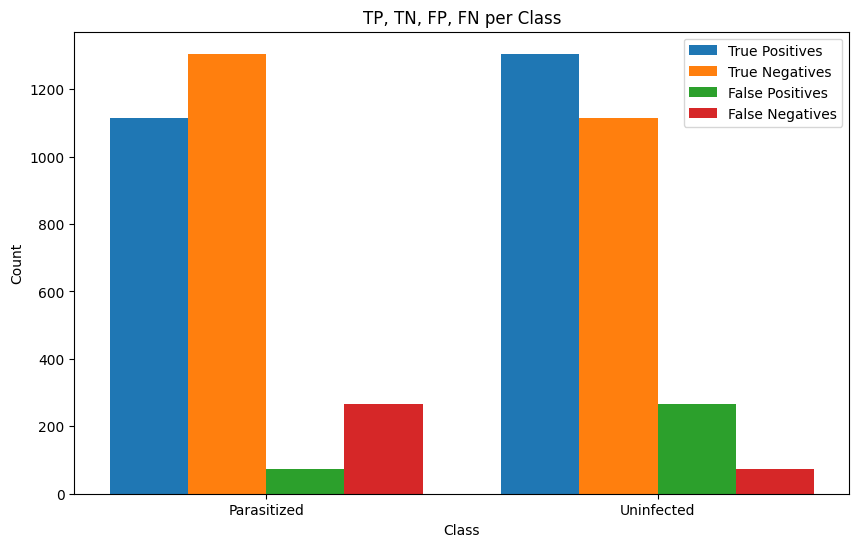

In [17]:
# Step 17: TP, TN, FP, FN bar plot
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = [np.delete(np.delete(cm, i, axis=0), i, axis=1).sum() for i in range(len(cm))]

x = np.arange(len(class_names))
width = 0.2
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - 1.5*width, TP, width, label='True Positives')
ax.bar(x - 0.5*width, TN, width, label='True Negatives')
ax.bar(x + 0.5*width, FP, width, label='False Positives')
ax.bar(x + 1.5*width, FN, width, label='False Negatives')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('TP, TN, FP, FN per Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names.values())
ax.legend()
plt.show()

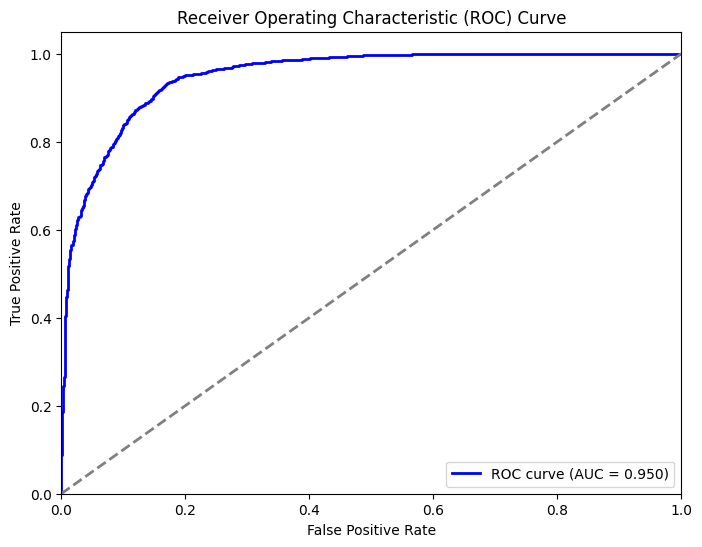

In [18]:
# Step 18: ROC Curve and AUC plot
fpr, tpr, _ = roc_curve(test_generator.classes, preds[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], color='grey', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


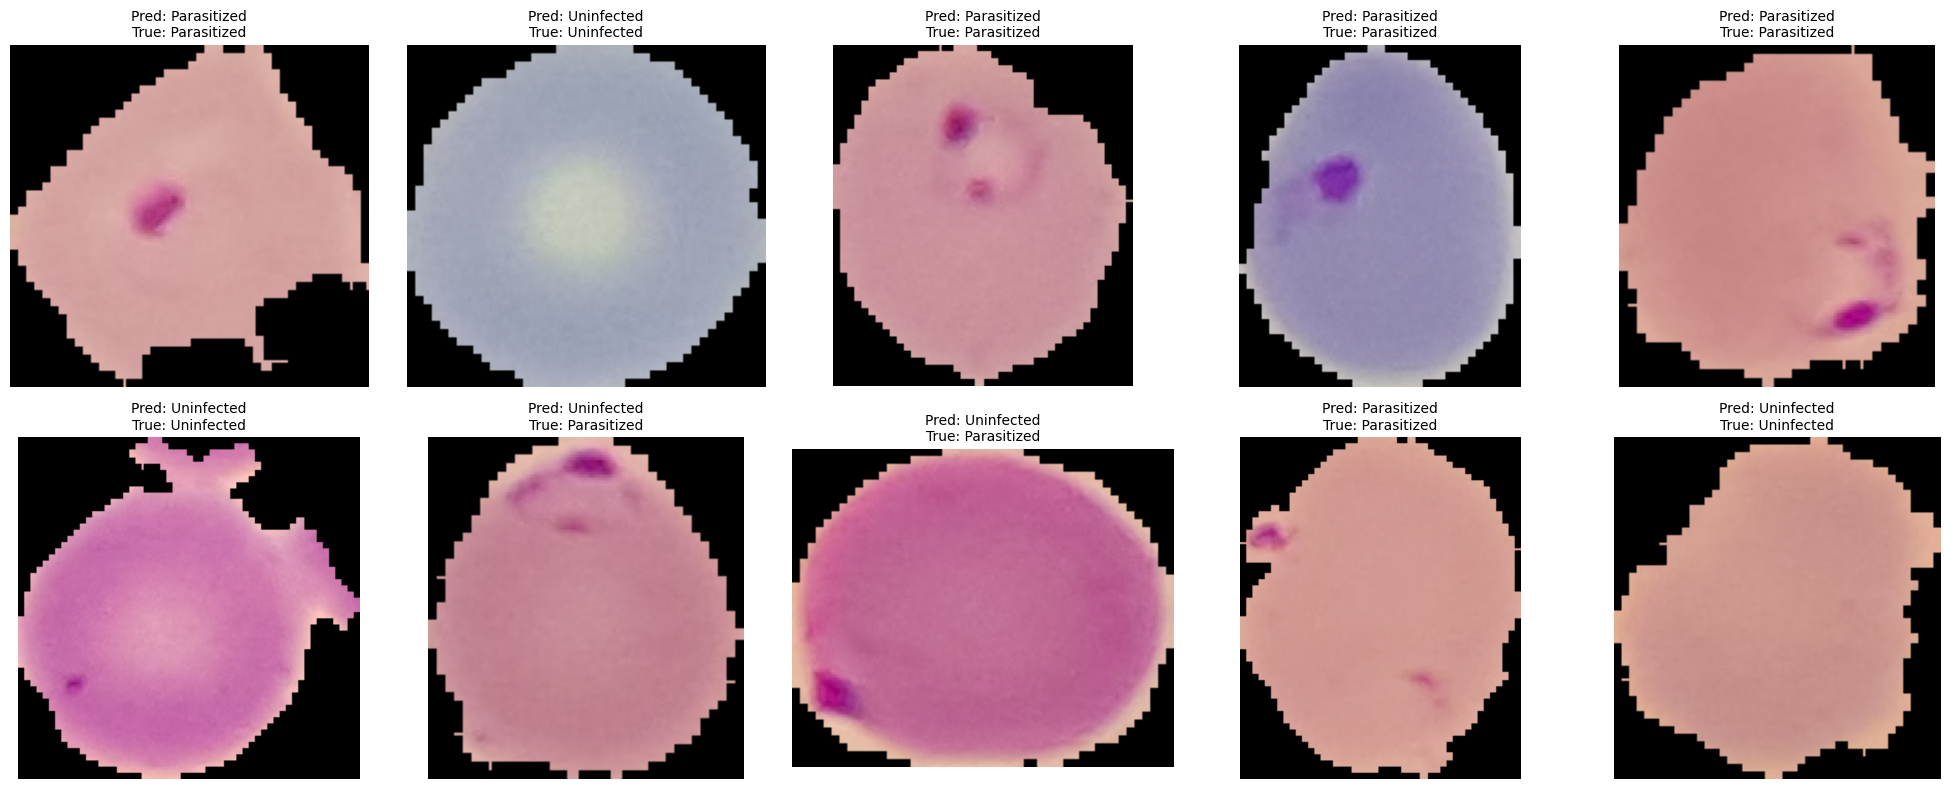

In [19]:
# Step 19: Visualize random test images with predictions
sample_files = random.sample(test_generator.filenames, 10)
plt.figure(figsize=(20,8))
for i, fname in enumerate(sample_files):
    plt.subplot(2, 5, i+1)
    img_path = os.path.join(test_dir, fname)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    img_obj = load_img(img_path, target_size=(128,128))
    img_arr = img_to_array(img_obj) / 255.0
    img_exp = np.expand_dims(img_arr, axis=0)
    pred = model.predict(img_exp)
    pred_label = class_names[np.argmax(pred)]
    true_label = os.path.basename(os.path.dirname(img_path))
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', fontsize=10)
plt.tight_layout()
plt.show()